# Starsim learning day - Diseases

This notebook provides an introduction to setting up diseases within Starsim. It is intended to be read in conjunction with the learning day presentation slides available at: https://docs.google.com/presentation/d/1HvIVCP8FKDtuZVmSbCRaITeG2rICCIDggcrBVP0Oe18/edit?usp=sharing. 

Some of these exercises are based closely on the Starsim tutorial on diseases, available at: https://docs.idmod.org/projects/starsim/en/latest/tutorials/tut_diseases.html.

## Starting with the basics: creating an SIR model using a dictionary
Let's start with the example covered in the overview slides from this morning (https://docs.google.com/presentation/d/1hvy3ws8XzvgOj63-juGjOWH2VesqUQ6448mCI4QPxDQ/edit?usp=sharing)

Note that even though we haven't covered networks yet, many of the diseases that we model transmit over contact networks, so we will include a simple contact network for this example and all others.

/Users/robynstuart/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Starsim 2.0.0 (2024-10-01) — © 2023-2024 by IDM
Initializing sim with 10000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.27 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.47 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.64 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.79 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.97 s)  •••••••••••••••••••• 100%



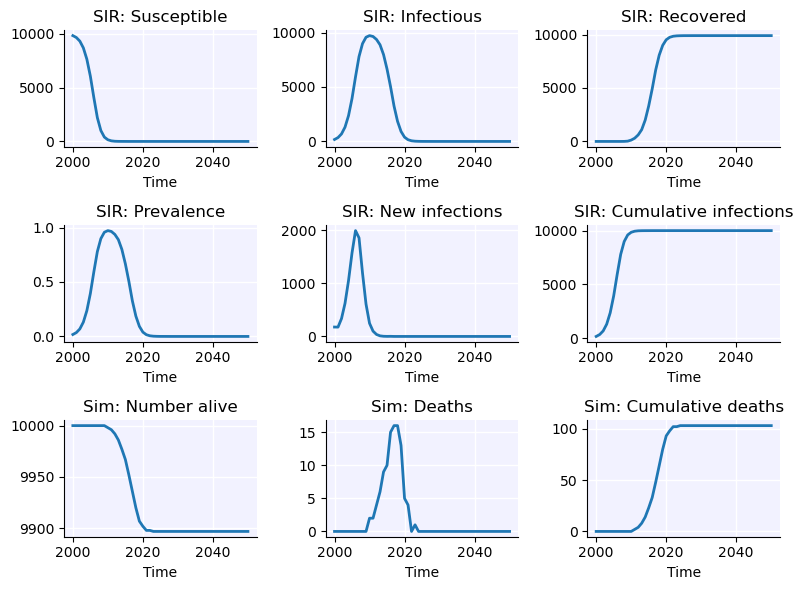

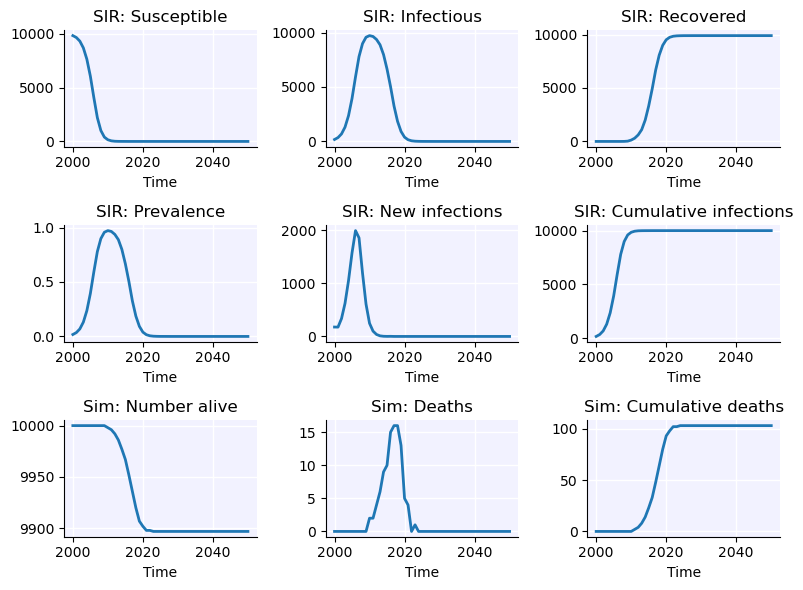

In [1]:
import starsim as ss

pars = dict(
   networks = 'random', # Random network
   diseases = dict(     # The SIR disease model, our focus for this sessoin
       type = 'sir',
       dur_inf = 10,
       beta = 0.1,
   )
)

sim = ss.Sim(pars)
sim.run()
sim.plot()


As we've seen, the code snippet above creates a simulation (`ss.Sim`) and plots it. In this most basic example, all the information about the disease itself was passed in as a dictionary: `dict(type = 'sir', dur_inf = 10, beta = 0.1)`. This tells the model to create an SIR model where we've specified that people are infected for 10 years (note that the default timestep for Starsim is years), and where the per-contact probability of transmission is 0.1. 

This is a simple way to get started, but to do anything more advanced with your disease model you will almost certainly need to set up your disease as a module. This is covered in the next section.

## Most common usage: creating an SIR model using a disease module
In the example above, we created a dictionary of parameters (`pars`) and passed this to the simulation (`ss.Sim`). However, it gives us a bit more flexibility if we define the disease as a module and pass that to the sim directly. The example above is equivalent to the example below:

In [5]:
sir = ss.SIR(beta=0.1, dur_inf=10)
network = ss.RandomNet()
sim = ss.Sim(diseases=sir, networks=network)

If you're using this notebook interactively, you can try plotting that sim to verify that it gives you the same output as the previous example did.

## Customizing the SIR model: changing parameters
The easiest way to customize the model is by changing the parameters. Even though this is a relatively simple example, we highlight it here because this is also the first step along the pathway to model calibration. 

In [ ]:
sir_10years = ss.SIR(beta=0.1, dur_inf=10, label='sir')
sir_20years = ss.SIR(beta=0.1, dur_inf=20, label='sir')
sim_10years = ss.Sim(diseases=sir_10years, networks=network, label='10 years')
sim_20years = ss.Sim(diseases=sir_20years, networks=network, label='20 years')
sim_10years.run()
sim_20years.run()

We can plot the two sims to see the differences:

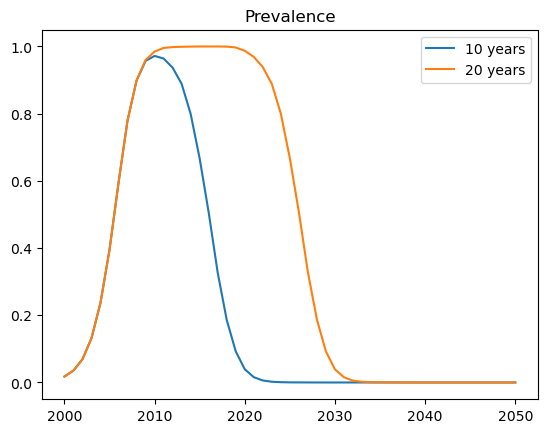

In [19]:
import pylab as pl
def plot_sims(*sims):
    pl.figure()
    for sim in sims:
        pl.plot(sim.results.timevec, sim.results.sir.prevalence, label=sim.label)
    pl.title('Prevalence')
    pl.legend()
    pl.show();
    
plot_sims(sim_10years, sim_20years)

## Changing the timescale
As mentioned above, the default timestep for Starsim is 1 year. There are various ways to change this. One option is to just adjust all you parameters accordingly, e.g. if you're modeling a disease with an infectious period of 2 weeks, you could enter `dur_inf=14/365`. However, Starsim also offers more support for using different units.

In the example below, we use a few new tricks. Firstly, when we create the disease module, we use `ss.beta` and `ss.dur`, two methods that help Starsim understand that we want it to be smart about handling the timesteps. Using `ss.dur()` allows you to say that the duration is in units of days, weeks, months, or years.  Then secondly, when we create the simulation, we provide a lot more information about time, including that we want to start on day 0 and run the simulation for 30 days.

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.00 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.34 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.53 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.69 s)  •••••••••••••••••••• 100%



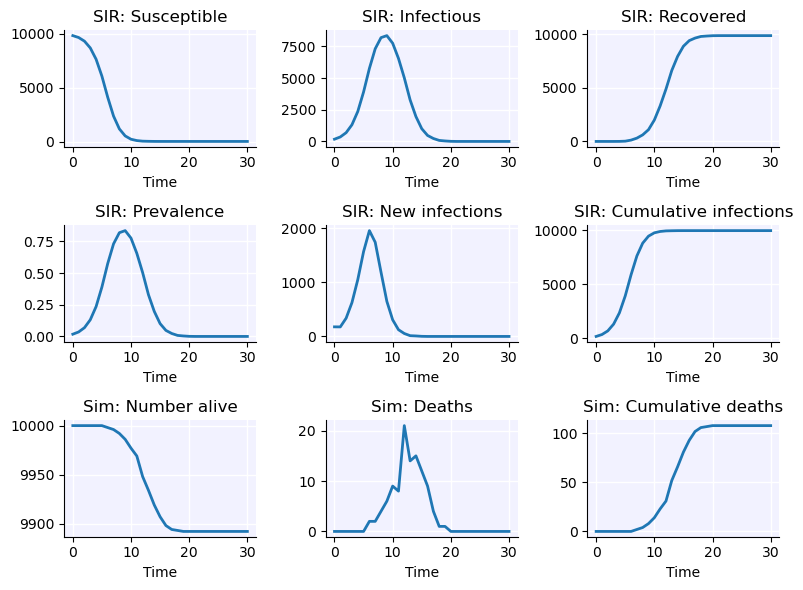

In [27]:
sir = ss.SIR(beta=ss.beta(0.1), dur_inf=ss.dur(10, 'days'))

# Simulate from 2020 for 1 month with a daily timestep
sim = ss.Sim(
    start=0,
    dur=30,
    unit='day',      
    diseases=sir,
    networks=network
)
sim.run()
sim.plot()

By using days, weeks, or months for our simulation timestep, we can adapt models that are much more suited for modeling outbreaks or diseases of short duration.

## Introducing variability
Rather than defining our model so that everyone is infected for 10 days, we can set it up so that the duration of infection is randomly distributed.

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.00 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.47 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.69 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.99 s)  •••••••••••••••••••• 100%



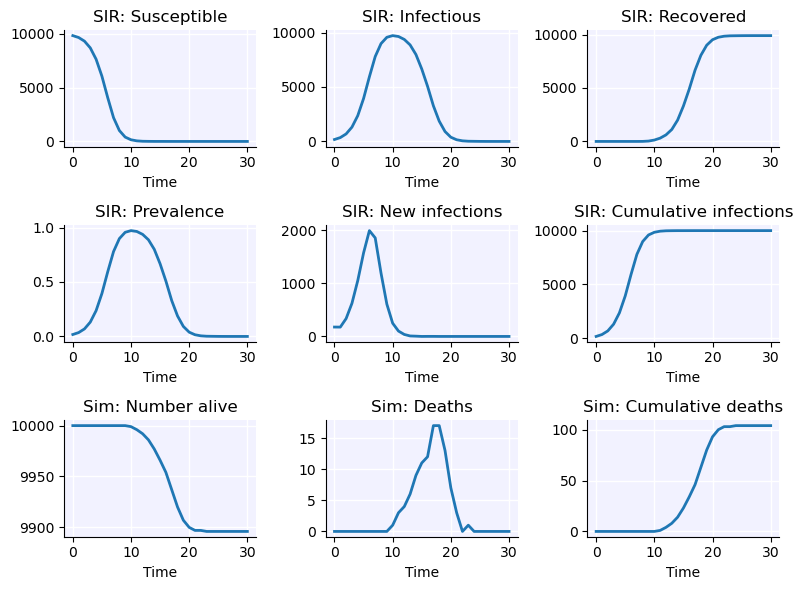

In [28]:
sir = ss.SIR(
    beta=ss.beta(0.1),
    dur_inf=ss.dur(ss.normal(loc=10, scale=1), 'day')
)
# Simulate from 2020 for 1 month with a daily timestep
sim = ss.Sim(
    start=0,
    dur=30,
    unit='day',      
    diseases=sir,
    networks=network
)
sim.run()
sim.plot()

## Other types of model
The default Starsim package includes a few different archtypes of diseases (SIR, SEIR, SIS), as well as a few examples of specific diseases (Ebola, measles, cholera... ). You can experiment with any of the examples in the same way that we have with the SIR model, by changing parameters. Often this is a gateway to the model calibration process, where you will typically adjust model parameters like we did in the first example with `dur_inf` to match surveillance data that you might have.

Getting familiar with the standard library of models is also the best pathway for learning how to create your own disease module. If you're interested in doing this, we have an advanced tutorial (https://docs.idmod.org/projects/starsim/en/latest/tutorials/dev_tut_diseases.html), and you may also like to look through some of our other repositories like STIsim (https://github.com/starsimhub/stisim) for inspiration on disease structure.

## Modeling multiple diseases together
Co-transmission modeling is one of Starsim's main selling points! Starsim has been specifically designed to make it simple and fast to model multiple diseases.

To add more that one disease, you can just pass the simulation a list of diseases rather than a single disease. In the example below, we also show how to set this up so that the diseases affect each other.

Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.23 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.50 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.68 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (1.28 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (1.41 s)  •••••••••••••••••••• 100%



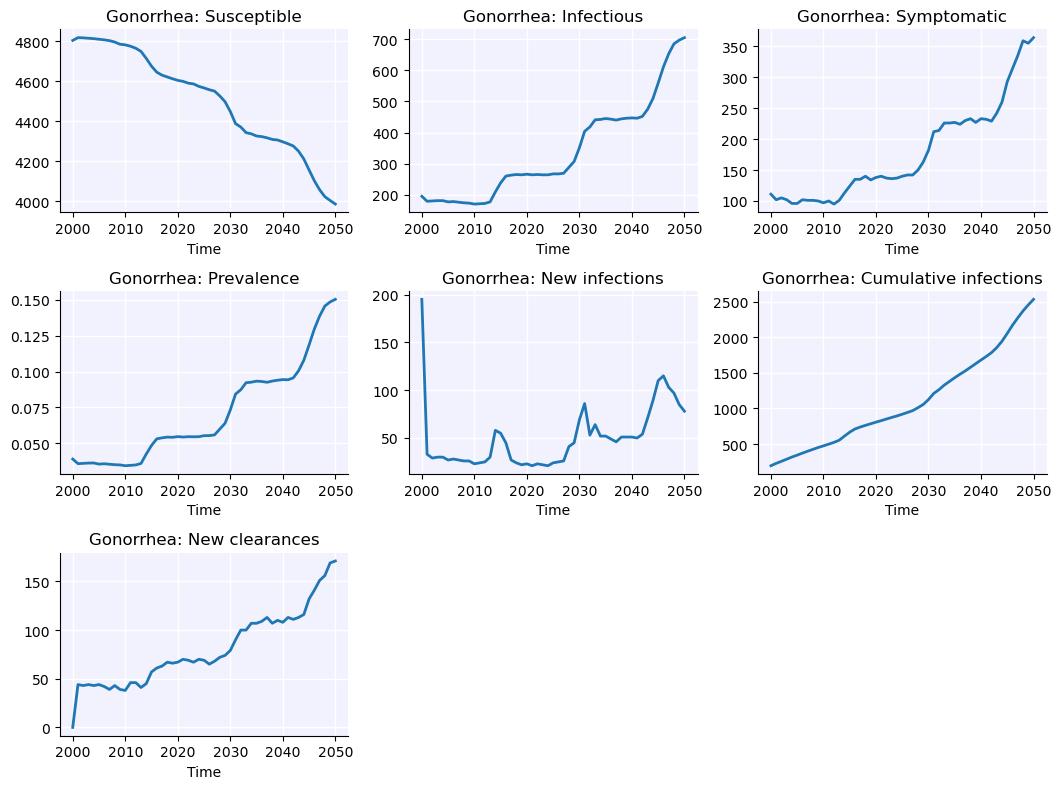

In [31]:
class simple_hiv_ng(ss.Module):
    """ Simple connector whereby rel_sus to NG doubles if CD4 count is <200"""
    def __init__(self, pars=None, label='HIV-Gonorrhea', **kwargs):
        super().__init__()
        self.define_pars(
            rel_trans_hiv  = 2,
            rel_trans_aids = 5,
            rel_sus_hiv    = 2,
            rel_sus_aids   = 5,
        )
        self.update_pars(pars, **kwargs)
        return

    def step(self):
        """ Specify how HIV increases NG rel_sus and rel_trans """
        people = self.sim.people
        people.gonorrhea.rel_sus[people.hiv.cd4 < 500] = self.pars.rel_sus_hiv
        people.gonorrhea.rel_sus[people.hiv.cd4 < 200] = self.pars.rel_sus_aids
        people.gonorrhea.rel_trans[people.hiv.cd4 < 500] = self.pars.rel_trans_hiv
        people.gonorrhea.rel_trans[people.hiv.cd4 < 200] = self.pars.rel_trans_aids
        return

# Make HIV
hiv = ss.HIV(
    beta = {'mf': [0.0008, 0.0004]},  # Specify transmissibility over the MF network
    init_prev = 0.05,
)

# Make gonorrhea
ng = ss.Gonorrhea(
    beta = {'mf': [0.05, 0.025]},  # Specify transmissibility over the MF network
    init_prev = 0.025,
)

# Make the sim, including a connector betweeh HIV and gonorrhea:
n_agents = 5_000
sim = ss.Sim(n_agents=n_agents, networks='mf', diseases=[simple_hiv_ng(), hiv, ng])
sim.run()
sim.plot('hiv')
sim.plot('gonorrhea')